In [108]:
import numpy as np
import codecs
import nltk
import lda
import sklearn
import string
import cPickle as pickle
import matplotlib.pyplot as plt
import collections, operator
import pandas as pd
import seaborn as sns
import matplotlib.gridspec as gridspec
from matplotlib import animation
from scipy.special import gammaln
from nltk.corpus import stopwords
from nltk.stem.porter import *
from collections import Counter, defaultdict
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from collections import defaultdict
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from wordcloud import WordCloud
plt.style.use("ggplot"); plt.style.use("bmh");
%matplotlib inline

#AM 207 Final Project
### Cole Diamond
### Raphael Pestourie
### Wei Dai

#Collapsed Gibbs Sampler for LDA to Classify Books by Thematic Content
<hr/>


# 1. Introduction 

LDA is a generative probabilistic model for collections of grouped discrete data. Each group is described as a random mixture over a set of latent topics where each topic is a discrete distribution over the collection’s vocabulary.  We use Gibbs sampling to sample from the posterior of the distribution described by LDA to extract thematic content from ten classic novels. We train on half of the pages, and perform inference on the remainder. We use nearest neighbor on the queried topic distibution to query the closest match. We were able to correctly label 100% of our test data with the correct title.



# 2. Methodology

##2.1. Pre-processing

* Our first step is to load the data from a folder containing all ten of the classic novels which compose our training corpus

In [39]:
import codecs
books = ["beowulf.txt", "divine_comedy.txt", "dracula.txt", "frankenstein.txt", "huck_finn.txt", "moby_dick.txt", "sherlock_holmes.txt", "tale_of_two_cities.txt", "the_republic.txt", "ulysses.txt"]
all_docs = []
for book in books:
    with codecs.open('data/%s'%(book), 'r', encoding='utf-8') as f:
        lines = f.read().splitlines() 
        all_docs.append(" ".join(lines))

- We remove punctuation and numbers from our books.
- Additionally, we remove stop words, or words that don't have much lexical meaning, ie: "the, is, at, which, on...". 

In [44]:
stemmer = PorterStemmer()
    
# def remove_insignificant_words(processed_docs, min_thresh = 9, intra_doc_thresh = .9):
#     all_tokens = np.unique([item for sublist in processed_docs for item in sublist])
#     low_freq_words = [k for k, v in Counter(all_tokens).iteritems() if v < min_thresh]
#     high_freq_words = []
#     for word in all_tokens:
#         num_docs_containing_word = np.sum(map(lambda doc: word in doc, processed_docs))
#         if float(num_docs_containing_word) / len(processed_docs) >= intra_doc_thresh:
#             high_freq_words.append(word)
#     words_to_remove = set(low_freq_words + high_freq_words)
#     return map(lambda doc_tokens: [w for w in doc_tokens if w not in words_to_remove], processed_docs)
    
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize_and_remove_grammar_numbers_stopwords(doc):
    doc = doc.lower()
    no_punctuation = re.sub(r'[^a-zA-Z\s]','',doc)
    tokens = nltk.word_tokenize(no_punctuation)
    filtered = [w for w in tokens if not w in stopwords.words('english')]
    #stemmed = stem_tokens(filtered, stemmer)
    #return stemmed
    return filtered

processed_docs = np.array(map(tokenize_and_remove_grammar_numbers_stopwords, all_docs))    
#processed_docs = remove_insignificant_words(processed_docs, all_tokens)

KeyboardInterrupt: 

In [43]:
processed_docs[0][500:510]

[u'tread',
 u'warrior',
 u'mail',
 u'viii',
 u'english',
 u'translations',
 u'beowulf',
 u'professor',
 u'garnett',
 u'alone']

In [570]:
np.save("temp_data/processed_docs.npy", processed_docs)

In [45]:
processed_docs = np.load("temp_data/processed_docs.npy")

## Build vocabulary 

In [38]:
vocab = np.unique(np.hstack(processed_docs.flat))
vocab_dict = {}
inv_vocab_dict = {}
for idx, w in enumerate(vocab):
    vocab_dict[w] = idx
    inv_vocab_dict[idx] = w

In [39]:
vocab[np.random.choice(vocab.size, 10)]

array([u'sacrament', u'bungardilaun', u'genevese', u'orhe', u'putting',
       u'forfeits', u'coverlet', u'connotation', u'loosning',
       u'sympathized'], 
      dtype='<U69')

##Map Docs to Vocab

- We now translate our documents into the language of numbers, allowing us to perform operations on our data

In [84]:
docs_as_nums = map(lambda doc: [vocab_dict[w] for w in doc], processed_docs)
docs_as_nums[0][:10]

[39038, 22075, 15318, 4485, 15318, 53645, 1932, 1940, 10849, 1375]

## Remove Low Frequency Words and Words that Appear Across >= 90% of Documents
* We remove words that will contribute very little to the signal we use to distinguish documents

In [ ]:
def freq_map(doc):
    out = np.zeros(vocab.size, dtype=np.int32)
    for w in doc:
        out[w] += 1
    return out

In [86]:
count_mat =np.array(map(freq_map, np.array(docs_as_nums)), dtype=np.int32)
low_freq_words = np.where(np.sum(td != 0, axis=0) < 2)
high_freq_words = np.where(np.sum(td > 0, axis=0) > .9*td.shape[0])
words_to_remove = np.unique(np.append(low_freq_words, high_freq_words))

In [89]:
docs_as_nums = map(lambda doc: [word for word in doc if word not in words_to_remove], docs_as_nums)

In [90]:
np.save("temp_data/docs_as_nums.npy", np.array(docs_as_nums))
docs_as_nums = np.load("temp_data/docs_as_nums.npy")

## Build Training and Test Set

- We split each of the books in half to use a training data and as test data, respectively.

In [91]:
test_docs, train_docs = [], []
for doc in docs_as_nums:
    test_docs.append(np.array(doc[0:len(doc)/2]))
    train_docs.append(np.array(doc[len(doc)/2:]))
test_docs, train_docs = np.array(test_docs), np.array(train_docs)

In [92]:
test_docs

array([array([56863,  1728, 16395, ..., 16542, 17462, 49986]),
       array([22076, 14172,  9563, ..., 50589, 27719, 18593]),
       array([40998,  3030,  8565, ...,  2660, 19071, 40388]),
       array([22076, 30986, 44646, ..., 13406, 28978, 25701]),
       array([  649, 18404,  9794, ..., 35857, 43281, 38739]),
       array([13364, 55565, 56864, ..., 55565, 39443,  5376]),
       array([22076,   649, 44675, ..., 45480, 44518, 43928]),
       array([ 8731,  8138, 13368, ..., 39574, 23695, 19646]),
       array([41306, 37635, 56864, ..., 26376, 24626, 13842]),
       array([52350, 27031, 56864, ..., 31075, 20261, 27920])], dtype=object)

## Build a Count Matrix

A count matrix is built by setting each row equal to the number of times a vocabulary word is used in a document. The count matrix has dimensions (num_docs x size_of_vocab). We need the count matrix because our LDA function will take it as an input.

In [93]:
train_count_mat = np.array(map(freq_map, train_docs), dtype=np.int32)
test_count_mat = np.array(map(freq_map, test_docs), dtype=np.int32)

In [94]:
train_count_mat

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [95]:
np.save("temp_data/train_count_mat.npy", train_count_mat)
np.save("temp_data/test_count_mat.npy", test_count_mat)

In [96]:
train_count_mat = np.load("temp_data/train_count_mat.npy")
test_count_mat = np.load("temp_data/test_count_mat.npy")

<hr/>
##2. LDA with Gibbs Sampling


LDA is a generative probabilistic model for collections of grouped discrete data. Each group is described as a random mixture over a set of latent topics where each topic is a discrete distribution over the collection’s vocabulary.  Algorithm 1 delineates how we can draw from the posterior of the LDA model using Gibbs Sampling

We define the following parameters whose relationship is described by the plate notation in Figure 1.

* α is the parameter of the Dirichlet prior on the per-document topic distributions,
* β is the parameter of the Dirichlet prior on the per-topic word distribution,
* $\theta_i$ is the topic distribution for document i,
* $\phi_k$ is the word distribution for topic k,
* $z_{ij}$ is the topic for the jth word in document i, and
* $w_{ij}$ is the specific word.


<img src="ipynb_assets/LDA Graph.png" height=300 style="float:left;">
<img src="ipynb_assets/LDA Gibbs.png" height=300>

* First, let's define our conditional distribution

In [97]:
def conditional_dist(alpha, beta, nwt, nd, nt, d, w):
    """
    Compute the conditional distribution
    """
    W = nwt.shape[0]
    p_z =  (ndt[d,:] + alpha) * ((nwt[w,:] + beta) / (nt + beta * W))
    # normalization
    p_z /= np.sum(p_z)
    return p_z

* We'll also need the log likelihood to verify that our model is converging

<img src="ipynb_assets/likelihood.png" height="75" >
<img src="ipynb_assets/multinomial beta.png" height="30">

In [98]:
def log_likelihood(alpha, beta, nwt, ndt, n_topics):
    """
    Compute the likelihood that the model generated the data.
    """
    W = nwt.shape[0]
    n_docs = ndt.shape[0]
    likelihood = 0

    for t in xrange(n_topics):
        likelihood += log_multinomial_beta(nwt[:,t]+beta) - log_multinomial_beta(beta, W)

    for d in xrange(n_docs):
        likelihood += log_multinomial_beta(ndt[d,:]+alpha) - log_multinomial_beta(alpha, n_topics)

    return likelihood

def log_multinomial_beta(alpha, K=None):
    """
    Logarithm of the multinomial beta function.
    """
    if K is None:
        return np.sum(gammaln(alpha)) - gammaln(np.sum(alpha))
    else:
        return K * gammaln(alpha) - gammaln(K*alpha)

- Since our input is a count matrix, we need to recover our document by multiplying the token by its frequency and combining (in any order since we have a bag of words assumption)

In [99]:
def word_indices(arr):
    """
    Transform a row of the count matrix into a document by replicating the token by its frequency
    """
    for idx in arr.nonzero()[0]:
        for i in xrange(int(arr[idx])):
            yield idx

- To perform LDA with Gibbs Sampling we need to initialize z randomly and initialize our counters.
- We set the number of topics to 1000.

In [136]:
n_topics = 15
alpha = .1 # prior weight of topic k in a document; few topics per document
beta = 0.05 # prior weight of word w in a topic; few words per topic
n_docs, W = train_count_mat.shape
# number of times document m and topic z co-occur
ndt = np.zeros((n_docs, n_topics))
# number of times word w and topic z co-occur
nwt = np.zeros((W, n_topics))
nd = np.zeros(n_docs)
nt = np.zeros(n_topics)
iters = 25
topics = defaultdict(dict)
delta_topics = []
delta_doc_topics = defaultdict(list)
likelihoods = []

for d in xrange(n_docs):
    # i is a number between 0 and doc_length-1
    # w is a number between 0 and W-1
    for i, w in enumerate(word_indices(train_count_mat[d, :])):
        # choose an arbitrary topic as first topic for word i
        t = np.random.randint(n_topics)
        ndt[d,t] += 1
        nd[d] += 1
        nwt[w,t] += 1
        nt[t] += 1
        topics[d][i] = t

* Now, we do Gibbs sampling for 25 iterations

In [137]:
# for each iteration
for it in xrange(iters):
    delta_topics_iteration = 0
    # for each doc
    for d in xrange(n_docs): 
        delta_doc_topics_iteration = 0
        # for each word
        for i, w in enumerate(word_indices(train_count_mat[d, :])):
            # get topic of mth document, ith word
            t = topics[d][i] 
            # decrement counters
            ndt[d,t] -= 1; nd[d] -= 1; nwt[w,t] -= 1; nt[t] -= 1

            p_z = conditional_dist(alpha, beta, nwt, nd, nt, d, w)
            t = np.random.multinomial(1,p_z).argmax()
            
            # increment counters
            ndt[d,t] += 1; nd[d] += 1; nwt[w,t] += 1; nt[t] += 1; 
            # increment convergence counter if the value for topic changes
            if topics[d][i] != t:
                delta_doc_topics_iteration += 1
                delta_topics_iteration += 1
                
            topics[d][i] = t
            
        delta_doc_topics[d].append(delta_doc_topics_iteration)
        
        
    print "-"*50, "\n Iteration", it+1, "\n", "-"*50, "\n"
    likelihood = log_likelihood(alpha, beta, nwt, ndt, n_topics)
    print "Likelihood", likelihood
    likelihoods.append(likelihood)
    print "Delta topics", delta_topics_iteration, "\n"
    delta_topics.append(delta_topics_iteration)
    

-------------------------------------------------- 
 Iteration 1 
-------------------------------------------------- 

Likelihood -2016318.2653
Delta topics 151491 

-------------------------------------------------- 
 Iteration 2 
-------------------------------------------------- 

Likelihood -1954272.72874
Delta topics 130623 

-------------------------------------------------- 
 Iteration 3 
-------------------------------------------------- 

Likelihood -1914306.9136
Delta topics 119274 

-------------------------------------------------- 
 Iteration 4 
-------------------------------------------------- 

Likelihood -1879696.39076
Delta topics 110393 

-------------------------------------------------- 
 Iteration 5 
-------------------------------------------------- 

Likelihood -1844837.71287
Delta topics 101531 

-------------------------------------------------- 
 Iteration 6 
-------------------------------------------------- 

Likelihood -1814085.40685
Delta topics 93269 

-

<hr/>
#3. Analysis


### Log Likelihood
We verify that the likelihood that our model generated the data increases over ever iteration. For convergence, we want to see a plateau, such that we are seeing diminishing gains in our log likelihood. As the graph below illustrates, this is exactly the case.

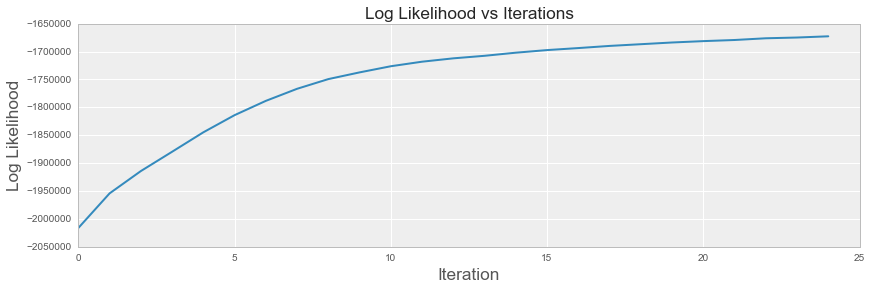

In [138]:
plt.style.use("ggplot");plt.style.use("bmh");

ax = plt.figure(figsize=(14,4))
plt.plot(np.arange(iters), likelihoods)
plt.title("Log Likelihood vs Iterations", fontsize="xx-large")
plt.xlabel("Iteration", fontsize="xx-large")
plt.ylabel("Log Likelihood", fontsize="xx-large")
plt.show()

### Aggregate Word-Topic Assignment Swaps
We present a custom statistic to measure the total number of words whose topic assignment changed between iterations. We know that if the algorithm converges, the number of swaps every iteration should level out. The graph below illustrates this trend.

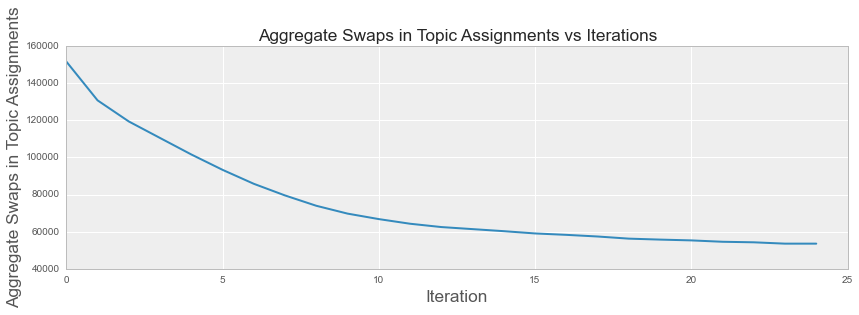

In [139]:
plt.figure(figsize=(14,4))
plt.plot(np.arange(iters), delta_topics)
plt.title("Aggregate Swaps in Topic Assignments vs Iterations", fontsize="xx-large")
plt.xlabel("Iteration", fontsize="xx-large")
plt.ylabel("Aggregate Swaps in Topic Assignments", fontsize="xx-large")
plt.show()

### Aggregate Word-Topic Assignment Swaps per Document
We apply the word-topic assignment swaps to a per-document basis. We should still see that on a document granularity, word-topic assignments should plateau. Each of the ten documents below illustrate this trend

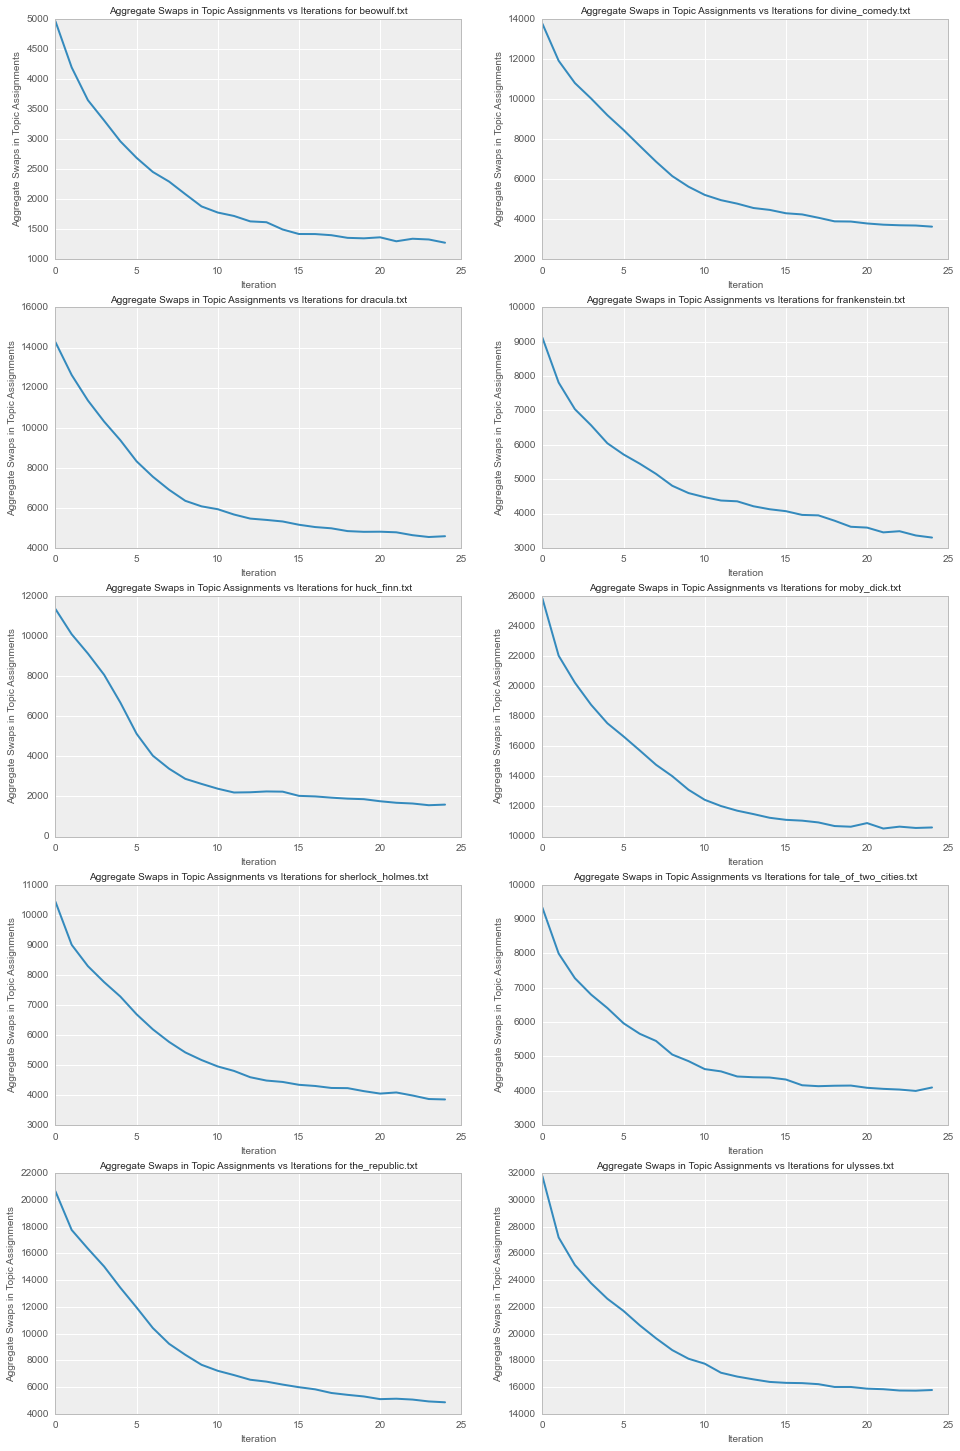

In [140]:
plt.figure(figsize=(16,25))
gs = gridspec.GridSpec(5, 2)
                       
for i in range(len(books)):
    ax = plt.subplot(gs[i])
    ax.plot(np.arange(iters), delta_doc_topics[i])
    ax.set_title("Aggregate Swaps in Topic Assignments vs Iterations for %s" %(books[i]), fontsize="medium")
    ax.set_xlabel("Iteration", fontsize="medium")
    ax.set_ylabel("Aggregate Swaps in Topic Assignments", fontsize="medium")

plt.show()

###Autocorrelation of Swaps

(0, 25)

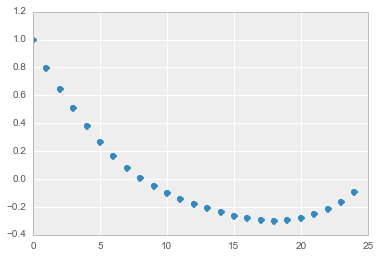

In [141]:
plt.acorr(delta_topics-np.mean(delta_topics),  normed=True, usevlines=False, maxlags=iters-1, label=u'Shuffled')
plt.xlim([0,iters])

###Topics as a Distribution over Words

- One important output of LDA is a matrix of topics where each topic is a distribution over the vocabulary.
- We want to verify that we observe only a few high-mass words per topic since we set our beta parameter to a small number (.5)

In [142]:
topic_words = defaultdict(lambda: [])
for d in xrange(n_docs): 
        for i, w in enumerate(word_indices(train_count_mat[d, :])):
            t = topics[d][i] 
            topic_words[t].append(inv_vocab_dict[w])

# Normalize
for topic in topic_words.keys():
    norm_topic_words = Counter(topic_words[topic])
    total = sum(norm_topic_words.values(), 0.0)
    for key in norm_topic_words:
        norm_topic_words[key] /= total
    topic_words[topic] = norm_topic_words

- Let's see what sort of topics LDA discovered. We will choose two topics at random

In [143]:
for i in np.random.choice(n_topics, 2):
    if topic_words[i]:
        sorted_topic_words = sorted(topic_words[i].items(), key=operator.itemgetter(1), reverse=True)
        print "\nMost important words for topic", i
        for word in sorted_topic_words[:10]:
            print word[0], word[1]


Most important words for topic 3
mrs 0.0114665057333
john 0.0106618386643
b 0.00794608730638
black 0.00694025347013
e 0.00543150271575
girl 0.00533091933213
simply 0.00492858579763
f 0.00492858579763
h 0.00422450211225
hate 0.00382216857775

Most important words for topic 1
deck 0.0247395833333
entire 0.0106770833333
calm 0.00833333333333
felix 0.00677083333333
flask 0.00651041666667
sank 0.00651041666667
creatures 0.00651041666667
regarded 0.00598958333333
swimming 0.00546875
history 0.00520833333333


* We can also visualize these topics as **wordclouds**

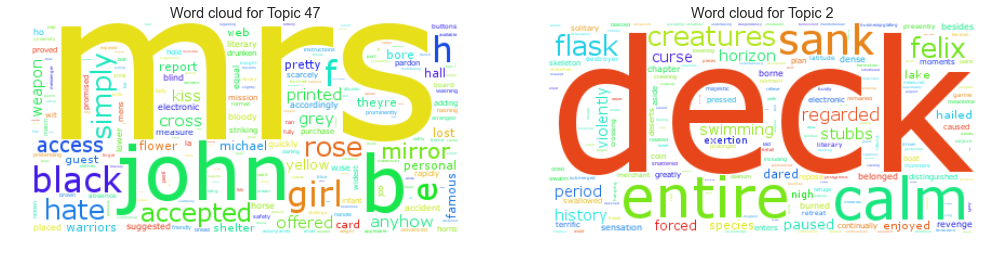

In [146]:
plt.figure(figsize=(17,10))
gs = gridspec.GridSpec(1, 2)

ax = plt.subplot(gs[0])
wc = WordCloud(font_path="Verdana.ttf", background_color="white")
wc.generate(" ".join([ (" " + word[0])*int(1000*word[1]) for word in topic_words[3].items()]))
ax.imshow(wc)
plt.axis("off")
ax.set_title("Word cloud for Topic 47")

ax = plt.subplot(gs[1])
wc = WordCloud(font_path="Verdana.ttf", background_color="white")
wc.generate(" ".join([ (" " + word[0])*int(1000*word[1]) for word in topic_words[1].items()]))
plt.imshow(wc)
plt.axis("off")
ax.set_title("Word cloud for Topic 2")

plt.show()

- Because we set our parameters to ensure sparsity over topics, each topic should be only described by a few words. Let's see a histogram to verify that the sparsity constraint was realized.

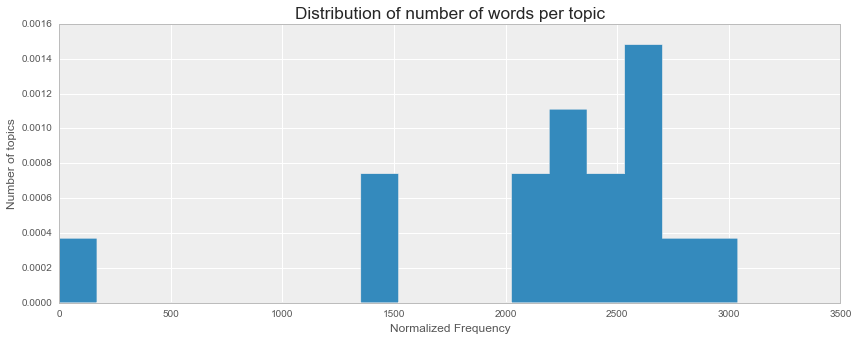

In [155]:
num_words_per_topic = [len(words) for topic, words in topic_words.iteritems()]
plt.figure(figsize=(14,5))
plt.hist(num_words_per_topic, bins=18, normed=True, histtype='stepfilled')
plt.title("Distribution of number of words per topic", fontsize="xx-large")
plt.xlabel("Normalized Frequency")
plt.ylabel("Number of topics")
plt.show()

### Documents as a Distribution over Topics

- Let's find our topic distributions over the train documents.
- We want to verify that we observe few high-mass topics per document since we set our alpha parameter to a large number (.8)

In [156]:
train_doc_topic_dist = np.zeros((n_docs, n_topics))
for d in xrange(n_docs): 
    # for each word
    for i, w in enumerate(word_indices(train_count_mat[d, :])):
        # get topic of mth document, ith word
        z = topics[d][i] 
        train_doc_topic_dist[d, z] += 1

# NORMALIZE TOPIC DISTRIBUTION
row_sums = train_doc_topic_dist.sum(axis=1)
train_doc_topic_dist = train_doc_topic_dist / row_sums[:, np.newaxis]

In [157]:
doc_topic_dist_df = pd.DataFrame(train_doc_topic_dist, columns=(["Topic " + str(i) for i in range(n_topics)]), index=([books[i] for i in range(n_docs)]))
doc_topic_dist_df

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14
beowulf.txt,0.000374,0.036864,0.000000,0.219686,0.010105,0.000000,0.009356,0.066430,0.009731,0.570734,0.000187,0.018525,0.000000,0.026572,0.031437
divine_comedy.txt,0.000000,0.001268,0.097030,0.025893,0.028562,0.002402,0.006607,0.029630,0.000067,0.490090,0.000000,0.005939,0.004671,0.024291,0.283550
dracula.txt,0.001735,0.005462,0.011630,0.087387,0.019983,0.015100,0.573411,0.102872,0.023068,0.003598,0.023325,0.008867,0.044015,0.051404,0.028144
frankenstein.txt,0.001798,0.110800,0.025177,0.040663,0.007993,0.000000,0.071935,0.374863,0.000000,0.019383,0.000200,0.004196,0.040963,0.166650,0.135378
huck_finn.txt,0.002178,0.000000,0.000081,0.009759,0.000081,0.003468,0.036293,0.010081,0.767481,0.000000,0.170094,0.000000,0.000000,0.000000,0.000484
moby_dick.txt,0.002668,0.063923,0.176939,0.019194,0.358625,0.021030,0.029380,0.048886,0.012923,0.067699,0.120258,0.008558,0.025881,0.026019,0.018016
sherlock_holmes.txt,0.011774,0.000171,0.010750,0.042232,0.004948,0.058016,0.271479,0.128487,0.022950,0.000000,0.024657,0.000000,0.344766,0.053920,0.025851
tale_of_two_cities.txt,0.369286,0.006328,0.112486,0.017567,0.005100,0.021345,0.138836,0.098224,0.012750,0.003495,0.030884,0.010861,0.075368,0.071779,0.025689
the_republic.txt,0.000387,0.000000,0.007315,0.013339,0.000000,0.002625,0.007831,0.131497,0.000387,0.004819,0.000000,0.456928,0.000645,0.315835,0.058391
ulysses.txt,0.013766,0.013846,0.023104,0.132748,0.022138,0.313369,0.050046,0.050529,0.044625,0.025975,0.141040,0.022916,0.067246,0.045081,0.033569


First, we can look at a heatmap of our topics over documents

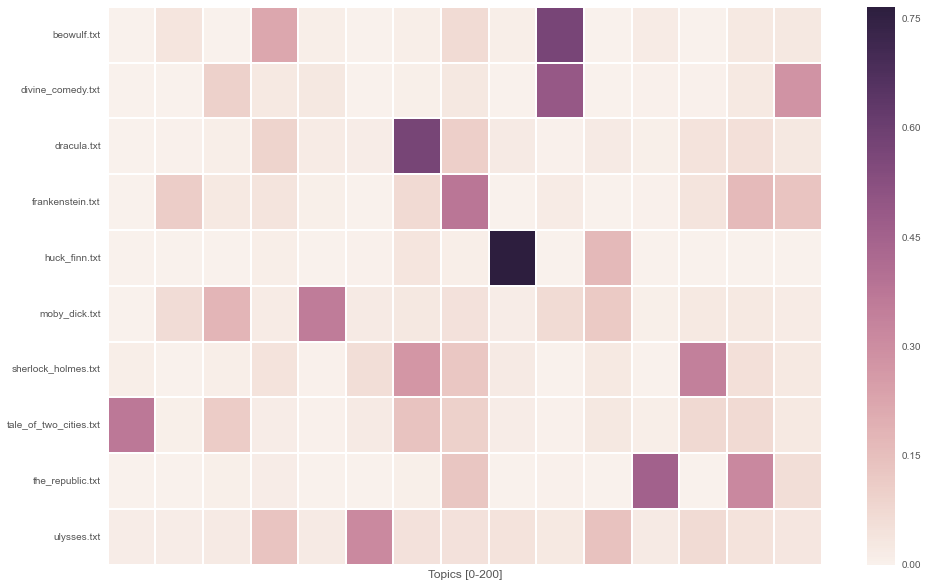

In [158]:
plt.figure(figsize=(16,10))
sns.heatmap(doc_topic_dist_df)
plt.gca().axes.get_xaxis().set_ticks([])
plt.xlabel("Topics [0-200]")
plt.show()

### 3D Visualization of Topic Density Across Documents

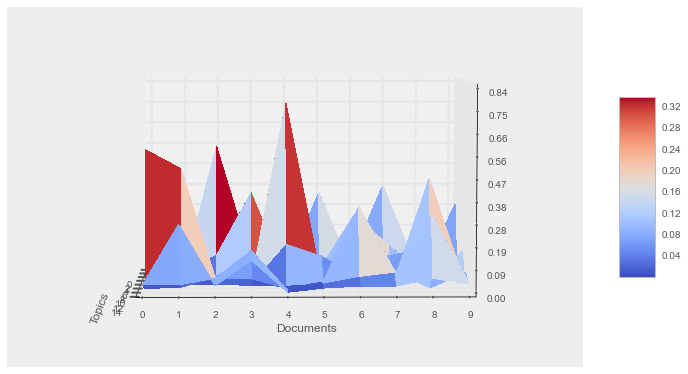

In [168]:
# Create an init function and the animate functions.
# Both are explained in the tutorial. Since we are changing
# the the elevation and azimuth and no objects are really
# changed on the plot we don't have to return anything from
# the init and animate function. (return value is explained
# in the tutorial.
def init():
    # Create a figure and a 3D Axes
    xx,yy = np.meshgrid(np.arange(n_topics),np.arange(n_docs)) # Define a mesh grid in the region of interest
    zz=train_doc_topic_dist
    surf = ax.plot_surface(xx, yy, zz, rstride=1, cstride=1, cmap=plt.cm.coolwarm, linewidth=0, antialiased=False)
    ax.view_init(elev=50., azim=250)
    ax.set_zlim(0.0001, np.max(train_doc_topic_dist)*1.1)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    ax.set_xlabel("Topics")
    ax.set_ylabel("Documents")
    fig.colorbar(surf, shrink=0.5, aspect=5)

def animate(i):
    ax.view_init(elev=5., azim=i)

# Animate
fig = plt.figure(figsize=(10,5))
ax = Axes3D(fig)
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=360, interval=20, blit=True)
# Save
anim.save('ipynb_assets/topic_dist_3D.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

In [170]:
from IPython.display import HTML
from base64 import b64encode
video = open("ipynb_assets/topic_dist_3D.mp4", "rb").read()
video_encoded = b64encode(video)
video_tag = '<video controls alt="test" src="data:video/x-m4v;base64,{0}">'.format(video_encoded)
HTML(data=video_tag)

### 2D Histogram of Topics over Documents

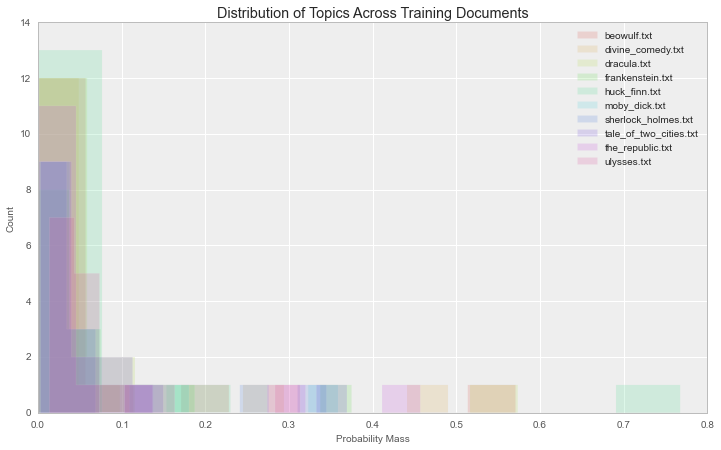

In [171]:
plt.figure(figsize=(12,7))
c = sns.color_palette("hls", n_docs)

for i in range(n_docs):
    plt.hist(train_doc_topic_dist[i, :], label=books[i], histtype="stepfilled", alpha=0.2, color=c[i])

plt.title("Distribution of Topics Across Training Documents")
plt.xlabel("Probability Mass", fontsize="medium")
plt.ylabel("Count", fontsize="medium")
plt.legend()
plt.show()

### Histogram of Topics Over Documents Individually

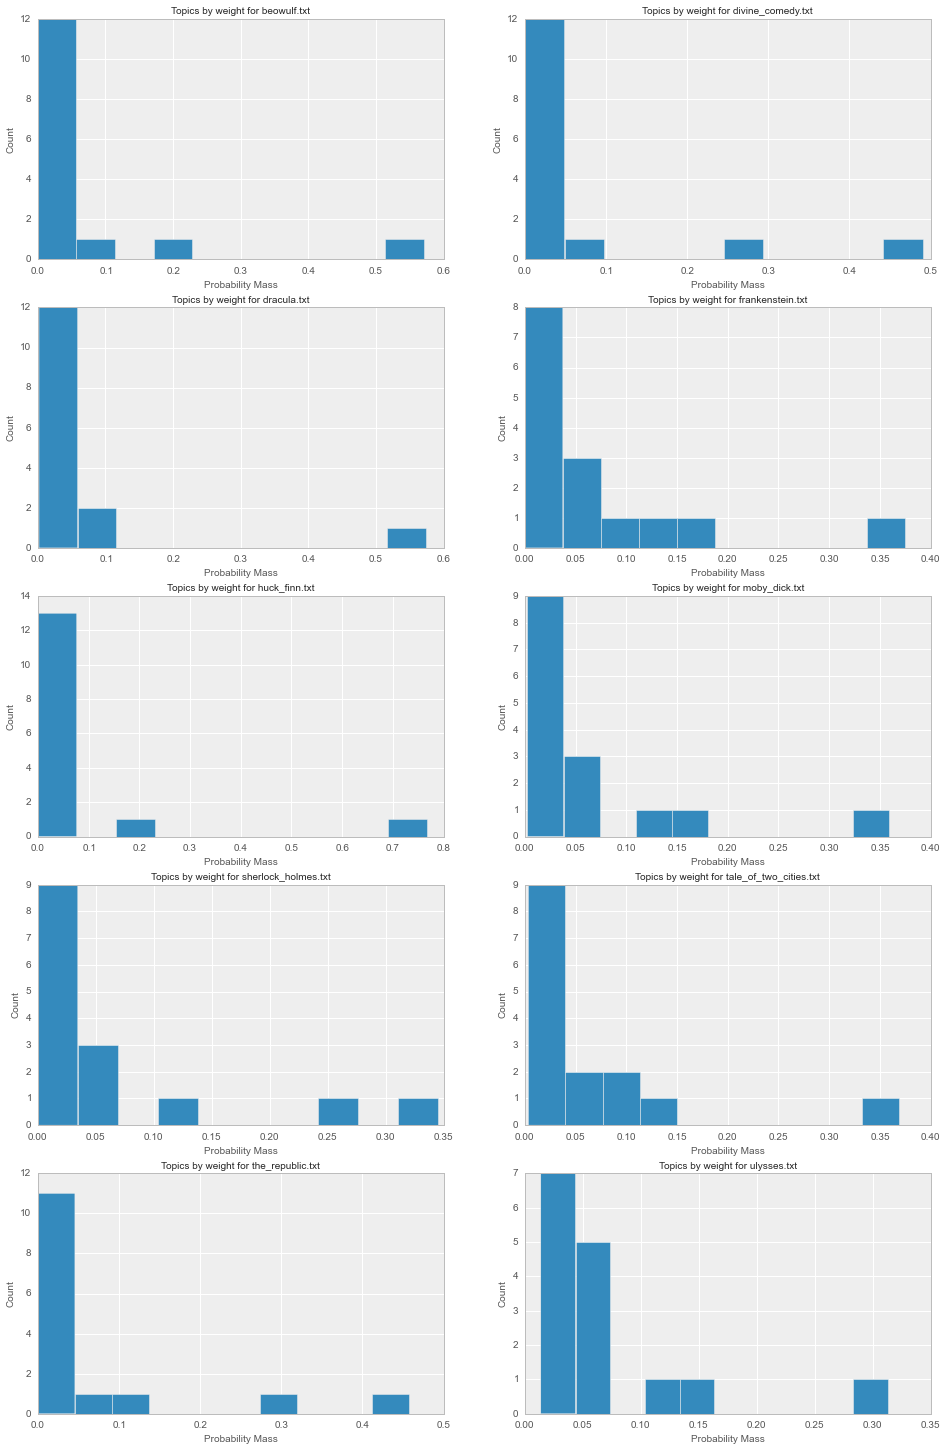

In [172]:
plt.figure(figsize=(16,25))
gs = gridspec.GridSpec(5, 2)
                       
for i in range(len(books)):
    ax = plt.subplot(gs[i])
    ax.hist(train_doc_topic_dist[i, :], log=False)
    ax.set_title("Topics by weight for %s" %(books[i]), fontsize="medium")
    ax.set_xlabel("Probability Mass", fontsize="medium")
    ax.set_ylabel("Count", fontsize="medium")

plt.show()

# 5. Prediction

* We want to see if we can use a document's topic distribution as a <b>unique signature</b> for classification
* Our theory is that topics across a book will remain <b>consistent</b>
    * So if we take new, unseen data from one of the books, compute its topic distribution, and compare it to the training data's topic distributions, we can know which book the unseen data came from!
    
* First, we retrain using our topic dict as a starting point. This will let us use our trained model to infer topics for each of the test documents' words better.

In [192]:
n_docs, W = test_count_mat.shape
# number of times document m and topic z co-occur
ndt_test = np.zeros((n_docs, n_topics))
# number of times word w and topic z co-occur
nwt_test = np.zeros((W, n_topics))
nd_test = np.zeros(n_docs)
nt_test = np.zeros(n_topics)
iters = 10
topics_test = topics
likelihoods_test = []

for d in xrange(n_docs):
    for i, w in enumerate(word_indices(test_count_mat[d, :])):
        t = np.random.randint(n_topics)
        ndt_test[d,t] += 1
        nd_test[d] += 1
        nwt_test[w,t] += 1
        nt_test[t] += 1
        topics_test[d][i] = t
        
# for each iteration
for it in xrange(iters):
    for d in xrange(n_docs): 
        for i, w in enumerate(word_indices(test_count_mat[d, :])):
            t = topics_test[d][i] 
            ndt_test[d,t] -= 1; nd_test[d] -= 1; nwt_test[w,t] -= 1; nt_test[t] -= 1

            p_z = conditional_dist(alpha, beta, nwt_test, nd_test, nt_test, d, w)
            t = np.random.multinomial(1,p_z).argmax()
            
            ndt_test[d,t] += 1; nd_test[d] += 1; nwt_test[w,t] += 1; nt_test[t] += 1; 
            topics_test[d][i] = t
        
    print "-"*50, "\n Iteration", it+1, "\n", "-"*50, "\n"
    likelihood = log_likelihood(alpha, beta, nwt_test, ndt_test, n_topics)
    print "Likelihood", likelihood
    likelihoods.append(likelihood)

-------------------------------------------------- 
 Iteration 1 
-------------------------------------------------- 

Likelihood -1819631.63548
-------------------------------------------------- 
 Iteration 2 
-------------------------------------------------- 

Likelihood -1728899.0533
-------------------------------------------------- 
 Iteration 3 
-------------------------------------------------- 

Likelihood -1700682.03445
-------------------------------------------------- 
 Iteration 4 
-------------------------------------------------- 

Likelihood -1687398.42742
-------------------------------------------------- 
 Iteration 5 
-------------------------------------------------- 

Likelihood -1680113.67774
-------------------------------------------------- 
 Iteration 6 
-------------------------------------------------- 

Likelihood -1674395.43854
-------------------------------------------------- 
 Iteration 7 
-------------------------------------------------- 

Likelihood -

- Now that we have trained our test model, we observe the topic distribution across the test documents.
    - we take the topic that maximizes the coniditional distribution, just as we did before.

In [196]:
test_doc_topic_dist = np.zeros((n_docs, n_topics))
for d in xrange(n_docs): 
    # for each word
    for i, w in enumerate(word_indices(test_count_mat[d, :])):
        # get topic of mth document, ith word
        p_z = conditional_dist(alpha, beta, nwt_test, nd_test, nt_test, d, w)
        z = np.random.multinomial(1,p_z).argmax()
        test_doc_topic_dist[d, z] += 1

# NORMALIZE TOPIC DISTRIBUTION
row_sums = test_doc_topic_dist.sum(axis=1) + 0.000001
test_doc_topic_dist = test_doc_topic_dist / row_sums[:, np.newaxis]

* We already have computed topic distributions over documents in our analysis, so now we can find the most similar topic distribution simply by computing the frobenius norm!

In [205]:
topic_distribution_norms = np.zeros((n_docs, n_docs))

for i in xrange(n_docs):
    query_dist = test_doc_topic_dist[i, :]
    for j in xrange(n_docs):
        topic_distribution_norms[i, j] = np.linalg.norm(train_doc_topic_dist[j, :] - query_dist)

mins = np.argmin(topic_distribution_norms, axis=1)
print mins

[0 1 2 3 4 5 6 7 8 9]


* Since the test documents are in order,  the indices should correspond to the label, which they do!

In [176]:
"Classification accuracy: %%%0.2f"%( 100*np.mean(np.array(books)[mins] == np.array(books)))

'Classification accuracy: %100.00'

## Conclusion

- We train an LDA model on half the pages of ten classic books, the other half is used for testing
- Given the test data and our model, we perform inference on the new text to determine the topic distribution. We compare the queried topic distribution with our training data, and assign it to the closest match.
- Our hypothesis that thematic content would be a good signal for identifying texts was valid
    - We achieved a perfect classification of our query text
- Future work may use bigrams or n-grams to map to topics, instead of unigrams